In [7]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.utils import pad_sequences, custom_object_scope
from tensorflow.keras.layers import MultiHeadAttention, Input, Dense, Embedding, GlobalAveragePooling1D, LayerNormalization, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.optimizers import Adam

# Load models and vectorizers
# Load models and vectorizers
with open('LRmodel.pkl', 'rb') as file:
    lr_model = pickle.load(file)

with open('LRvectorizer.pkl', 'rb') as file:
    lr_vectorizer = pickle.load(file)

with open('SVMmodel.pkl', 'rb') as file:
    svm_model = pickle.load(file)

with open('SVMvectorizer.pkl', 'rb') as file:
    svm_vectorizer = pickle.load(file)

with open('xgb_model.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

with open('tfidf_vectorizer.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)

with open('label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

lstm_model = load_model('lstm_model.h5')

with open('LSTM_tokenizer.pkl', 'rb') as file:
    lstm_tokenizer = pickle.load(file)

with open('NBmodel.pkl', 'rb') as file:
    nb_model = pickle.load(file)

with open('NBvectorizer.pkl', 'rb') as file:
    nb_vectorizer = pickle.load(file)

# Load the transformer model and associated files
with open('Tlabel_encoder.pkl', 'rb') as file:
    t_label_encoder = pickle.load(file)

with open('Tvectorize_layer.pkl', 'rb') as file:
    t_vectorize_layer = pickle.load(file)

# Define the custom layers
class EmbeddingLayer(Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(EmbeddingLayer, self).__init__(**kwargs)
        self.word_embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embedding = Embedding(input_dim=sequence_length, output_dim=embed_dim)

    def call(self, tokens):
        sequence_length = tf.shape(tokens)[-1]
        positions = tf.range(start=0, limit=sequence_length, delta=1)
        positions_encoding = self.position_embedding(positions)
        words_encoding = self.word_embedding(tokens)
        return positions_encoding + words_encoding


class EncoderLayer(Layer):
    def __init__(self, total_heads, total_dense_units, embed_dim, **kwargs):
        super(EncoderLayer, self).__init__(**kwargs)
        self.multihead = MultiHeadAttention(num_heads=total_heads, key_dim=embed_dim)
        self.nnw = Sequential([Dense(total_dense_units, activation="relu"), Dense(embed_dim)])
        self.normalize_layer = LayerNormalization()

    def call(self, inputs):
        attn_output = self.multihead(inputs, inputs)
        normalize_attn = self.normalize_layer(inputs + attn_output)
        nnw_output = self.nnw(normalize_attn)
        final_output = self.normalize_layer(normalize_attn + nnw_output)
        return final_output


# Load the saved transformer model with custom objects
custom_objects = {
    "EmbeddingLayer": EmbeddingLayer,
    "EncoderLayer": EncoderLayer
}

transformer_model = load_model('Ttransformer_model.h5', custom_objects=custom_objects)


# Load the test dataset
data = pd.read_csv('preprocessed_mental_health.csv')
data.dropna(subset=['cleaned_text'], inplace=True)

X_test = data['cleaned_text']
y_test = data['mental_health_issue']
y_test = label_encoder.transform(y_test)

# Preprocess the text
X_test_lr = lr_vectorizer.transform(X_test)
X_test_svm = svm_vectorizer.transform(X_test)
X_test_nb = nb_vectorizer.transform(X_test)
X_test_xgb = tfidf_vectorizer.transform(X_test)
X_test_lstm = lstm_tokenizer.texts_to_sequences(X_test)
X_test_lstm = pad_sequences(X_test_lstm, maxlen=100, padding='post', truncating='post')
# Preprocess the text for the transformer model
X_test_transformer = t_vectorize_layer(X_test)

# Get individual model probabilities
lr_predictions_proba = lr_model.predict_proba(X_test_lr)
svm_predictions_proba = svm_model.predict_proba(X_test_svm)
nb_predictions_proba = nb_model.predict_proba(X_test_nb)
xgb_predictions_proba = xgb_model.predict_proba(X_test_xgb)
lstm_predictions_proba = lstm_model.predict(X_test_lstm)
# Get probabilities from the transformer model
transformer_predictions_proba = transformer_model.predict(X_test_transformer)

# Stack the predictions to create the feature matrix for the meta-learner
stacked_features = np.hstack((
    lr_predictions_proba,
    svm_predictions_proba,
    nb_predictions_proba,
    xgb_predictions_proba,
    lstm_predictions_proba,
    transformer_predictions_proba  # Add transformer probabilities
))

# Split data into training and test sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    stacked_features, y_test, test_size=0.2, random_state=42, stratify=y_test
)

# Train Random Forest as the meta-learner
meta_learner_rf = RandomForestClassifier(
    max_depth=None,            # Maximum depth of each tree
    min_samples_split=20,      # Minimum number of samples to split a node

    min_samples_leaf=1,        # Minimum number of samples in a leaf node
    max_features='sqrt',       # Number of features to consider at each split
    bootstrap=False,            # Whether to use bootstrapping

    random_state=42            # For reproducibility
    )
meta_learner_rf.fit(X_train1, y_train1)

# Save the trained Random Forest meta-learner
with open('meta_learner_rf.pkl', 'wb') as file:
    pickle.dump(meta_learner_rf, file)

# Predict using the Random Forest meta-learner
final_predictions_rf = meta_learner_rf.predict(X_test1)

# Evaluate the Random Forest ensemble model
accuracy_rf = accuracy_score(y_test1, final_predictions_rf)
report_rf = classification_report(y_test1, final_predictions_rf, target_names=label_encoder.classes_)

print(f"Random Forest Meta-Learner Accuracy: {accuracy_rf * 100:.2f}%")
print("Classification Report (Random Forest):\n", report_rf)
print("Confusion Matrix (Random Forest):\n", confusion_matrix(y_test1, final_predictions_rf))

# Calculate the mean and standard deviation of validation accuracies
cross_val_accuracies = cross_val_score(
    meta_learner_rf, stacked_features, y_test, cv=5, scoring='accuracy'
)

mean_val_accuracy = np.mean(cross_val_accuracies)
std_val_accuracy = np.std(cross_val_accuracies)

# Print cross-validation results
print(f"Cross-Validation Accuracies: {cross_val_accuracies}")
print(f"Mean Validation Accuracy: {mean_val_accuracy * 100:.2f}%")
print(f"Validation Accuracy Std Dev: {std_val_accuracy * 100:.2f}%")

581/581 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Random Forest Meta-Learner Accuracy: 98.20%
Classification Report (Random Forest):
               precision    recall  f1-score   support

     anxiety       0.98      0.97      0.98       400
     bipolar       0.96      0.93      0.95       388
  depression       0.97      0.97      0.97       392
      normal       0.99      1.00      0.99      2136
        ptsd       0.98      0.98      0.98       397

    accuracy                           0.98      3713
   macro avg       0.98      0.97      0.97      3713
weighted avg       0.98      0.98      0.98      3713

Confusion Matrix (Random Forest):
 [[ 390    1    5    1    3]
 [   2  361    4   19    2]
 [   6    2  379    1    4]
 [   0   10    0 2126    0]
 [   1    2    2    2  390]]
Cross-Validation Accuracies: [0.98303259 0.97576084 0.98384056 0.97145166 0.98007002]
Mean Validation Accuracy: 97.88%
Validation Accuracy Std Dev: 0.47%


In [8]:
from sklearn.model_selection import StratifiedKFold

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform stratified cross-validation and compute accuracies
cross_val_accuracies = []
for train_index, test_index in skf.split(stacked_features, y_test):
    X_train_fold, X_test_fold = stacked_features[train_index], stacked_features[test_index]
    y_train_fold, y_test_fold = y_test[train_index], y_test[test_index]

    meta_learner_rf.fit(X_train_fold, y_train_fold)
    fold_accuracy = meta_learner_rf.score(X_test_fold, y_test_fold)
    cross_val_accuracies.append(fold_accuracy)

# Convert to NumPy array for consistency
cross_val_accuracies = np.array(cross_val_accuracies)

# Calculate mean and standard deviation
mean_val_accuracy = np.mean(cross_val_accuracies)
std_val_accuracy = np.std(cross_val_accuracies)

# Print cross-validation results
print(f"Cross-Validation Accuracies: {cross_val_accuracies}")
print(f"Mean Validation Accuracy: {mean_val_accuracy * 100:.2f}%")
print(f"Validation Accuracy Std Dev: {std_val_accuracy * 100:.2f}%")


Cross-Validation Accuracies: [0.980878   0.97899273 0.98410988 0.98168597 0.97764611]
Mean Validation Accuracy: 98.07%
Validation Accuracy Std Dev: 0.22%


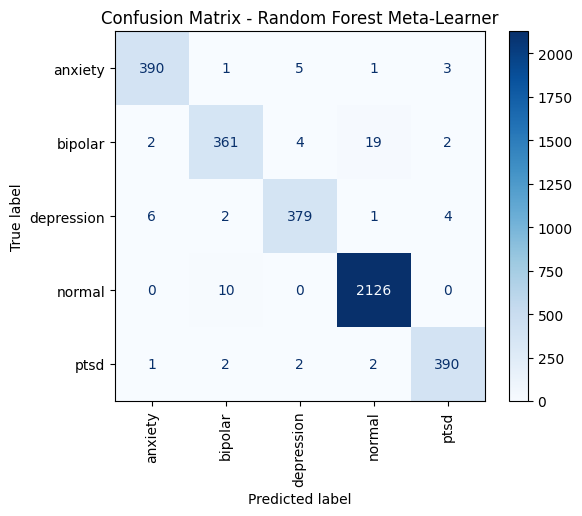

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test1, final_predictions_rf),
                              display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix - Random Forest Meta-Learner")
plt.show()


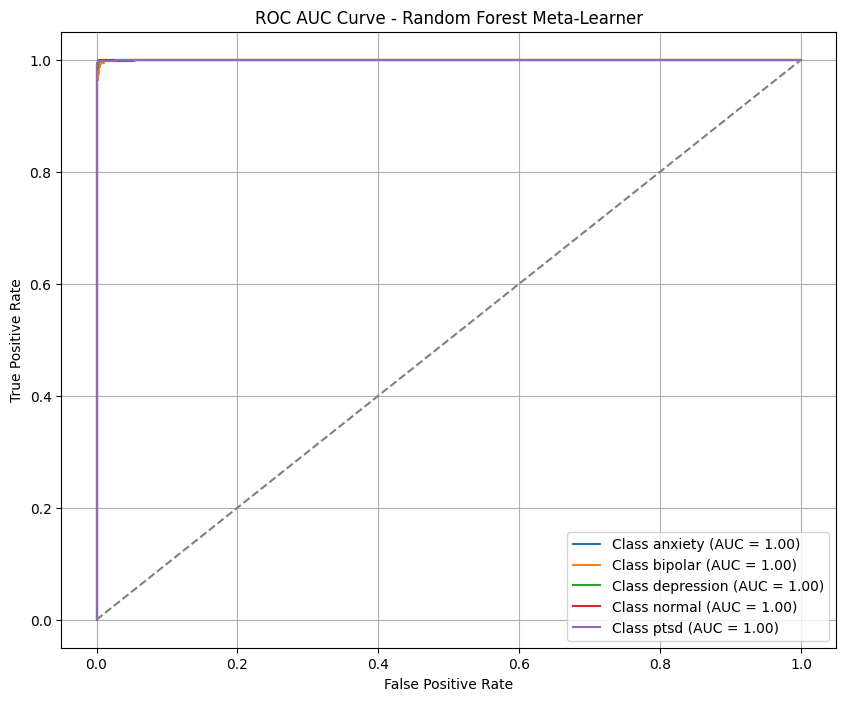

In [10]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels for ROC AUC calculation
y_test1_bin = label_binarize(y_test1, classes=np.arange(len(label_encoder.classes_)))

# Predict probabilities for test data
final_predictions_proba = meta_learner_rf.predict_proba(X_test1)

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(label_encoder.classes_)):
    fpr, tpr, _ = roc_curve(y_test1_bin[:, i], final_predictions_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {label_encoder.classes_[i]} (AUC = {roc_auc:.2f})")

# Plot the random classifier line
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

# Add labels and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC Curve - Random Forest Meta-Learner")
plt.legend(loc="lower right")
plt.grid()
plt.show()
